In [47]:
import os
import glob   # file path
import scipy
import numpy as np # matrix process
import matplotlib.pyplot as plt  #graph
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array #train
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input #MoblieNetV2 is the model we use
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


In [48]:
from google.colab import drive #mounting drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf      #gpu test
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6927054717181155943, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10012200599935250465
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
os.chdir(r'/content/drive/MyDrive/test')


In [ ]:
os.listdir(os.getcwd())

['e1.jpg', 'f1.jpg', 'e2.jpg', 'f2.jpg']

# Preview Dataset

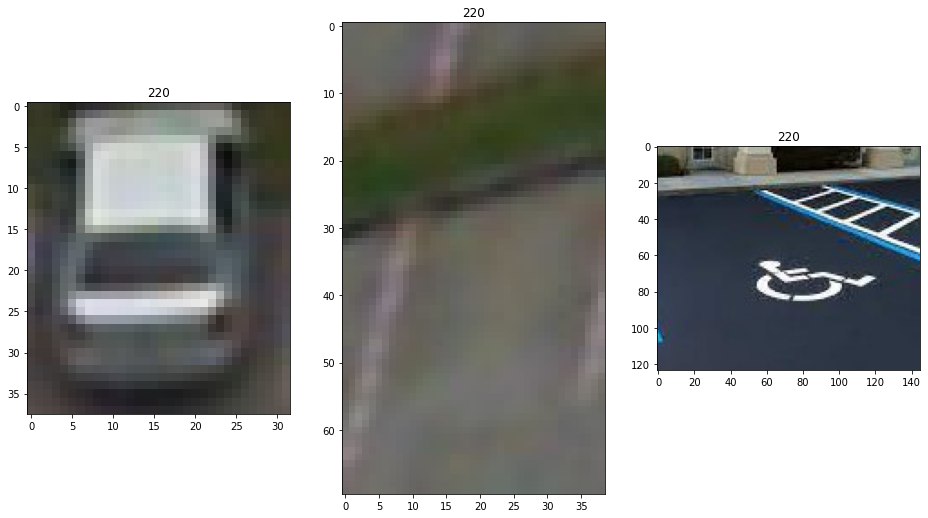

In [55]:
os.chdir(r'/content/drive/MyDrive/test')
full_list = glob.glob(r'./train/full/*.jpg')
free_list = glob.glob(r'./train/empty/*.jpg')
disabled_list = glob.glob(r'./train/Disabled/*.jpg')

full_img = img_to_array(load_img(full_list[0]), dtype=np.uint8)
free_img = img_to_array(load_img(free_list[0]), dtype=np.uint8)
disabled_img = img_to_array(load_img(disabled_list[0]), dtype=np.uint8)

fig, ax = plt.subplots(1,3, figsize=(16,16))
ax = ax.ravel()

ax[0].set_title(len(full_list))     #shows how many on the data set
ax[0].imshow(full_img)

ax[1].set_title(len(free_list))
ax[1].imshow(free_img)

ax[2].set_title(len(disabled_list))
ax[2].imshow(disabled_img)

# DataGenerator

In [56]:
train_datagen = ImageDataGenerator(
    
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True,
    shear_range=0.01,
    zoom_range=[0.8, 1.2],
    validation_split=0.1,    # take 10% as validation data
    preprocessing_function=preprocess_input
)
np.random.seed(10)

val_datagen = ImageDataGenerator(
    validation_split=0.1,                   # take 10% as validation data
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    r'./train',
    target_size=(224, 224),   # for MobileNetV2
    classes=['full', 'empty', 'Disabled'],
    class_mode='categorical',     
    batch_size=16,
    subset='training'
)

val_gen = val_datagen.flow_from_directory(
    r'./train',
    target_size=(224, 224),
    classes=['full', 'empty', 'Disabled'],
    class_mode='categorical',
    batch_size=16,
    shuffle=False,
    subset='validation'
)

print(val_gen.class_indices)

Found 594 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
{'full': 0, 'empty': 1, 'Disabled': 2}


# Load Model for Transfer Learning

In [57]:
base_model = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x) # stretching data to 1D
output = Dense(3, activation='softmax')(x) #2 ouputs -> 3outputs

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_11[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
___________________________________________________________________________________________

# Switch Layers to be Trainable

In [58]:
for layer in model.layers:
    layer.trainable = True # in case the weight doesn't change

# Train

In [59]:
history = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    epochs=50, # re-train number
     callbacks=[
        ModelCheckpoint('model.h5', monitor='val_acc', save_best_only=True,verbose=1), #take the best one
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, verbose=1, mode='auto', min_lr=1e-05)
     ]
    
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
38/38 [==============================] - 15s 304ms/step - loss: 0.3534 - acc: 0.8530 - val_loss: 26.4517 - val_acc: 0.5455

Epoch 00001: val_acc improved from -inf to 0.54545, saving model to model.h5
Epoch 2/50
38/38 [==============================] - 11s 288ms/step - loss: 0.2723 - acc: 0.9439 - val_loss: 7.7559 - val_acc: 0.6667

Epoch 00002: val_acc improved from 0.54545 to 0.66667, saving model to model.h5
Epoch 3/50
38/38 [==============================] - 11s 289ms/step - loss: 0.1399 - acc: 0.9588 - val_loss: 11.6320 - val_acc: 0.4697

Epoch 00003: val_acc did not improve from 0.66667
Epoch 4/50
38/38 [==============================] - 11s 284ms/step - loss: 0.3213 - acc: 0.9274 - val_loss: 1.5044 - val_acc: 0.5000

Epoch 00004: val_acc did not improve from 0.66667
Epoch 5/50
38/38 [==============================] - 11s 287ms/step - loss: 0.2219 - acc: 0.9333 - val_loss: 3.9410 - val_acc: 0.6364

Epoch 00005: val_acc did not improve from 0.66667
Epoch 6/50
38/38 [===

# Create New Model

In [ ]:
model = load_model('model.h5')

last_weight = model.layers[-1].get_weights()[0] # (1280, 3)
   
new_model = Model(
    inputs=model.input,
    outputs=(
        model.layers[-3].output, # the layer just before GAP, for using spatial features
        model.layers[-1].output
    )
)

new_model.summary()

KeyboardInterrupt: ignored

# Normal Prediction

[[3.2361218e-11 1.0000000e+00 1.1693133e-10]]


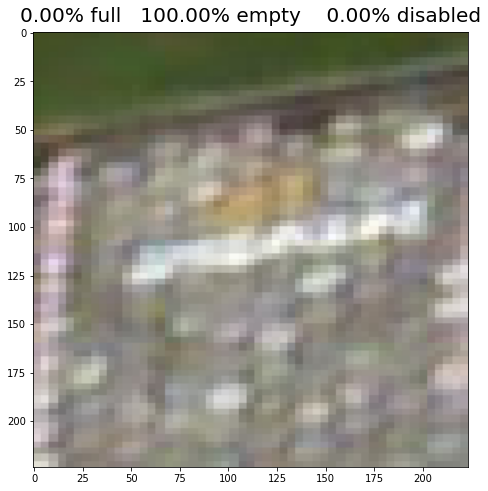

In [68]:
'''
'./data/Test/e2.jpg'
 full_list[]
 free_list[]
 disabled_list[]
'''
model = load_model('model.h5')
os.chdir(r'/content/drive/MyDrive/test')
test_img = img_to_array(load_img('./test_set/test4.jpg', target_size=(224, 224)))

test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))

pred = model.predict(test_input) # predict
print(pred)
plt.figure(figsize=(8, 8))
plt.title('%.2f%% full   %.2f%% empty    %.2f%% disabled' % (pred[0][0] * 100, pred[0][1] * 100,pred[0][2] * 100),fontsize=20, pad=10)

plt.imshow(test_img.astype(np.uint8))

# Draw Activation Map

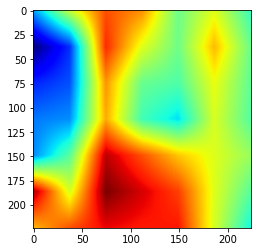

In [ ]:
last_conv_output, pred = new_model.predict(test_input)

last_conv_output = np.squeeze(last_conv_output) # (7, 7, 1280)
feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # (7, 7, 1280) -> (224, 224, 1280)

pred_class = np.argmax(pred) # 0: Full, 1: Free
predicted_class_weights = last_weight[:, pred_class] # (1280, 1)

final_output = np.dot(feature_activation_maps.reshape((224*224, 1280)), predicted_class_weights).reshape((224, 224)) # (224*224, 1280) dot_product (1280, 1) = (224*224, 1)

plt.imshow(final_output, cmap='jet')

# Result

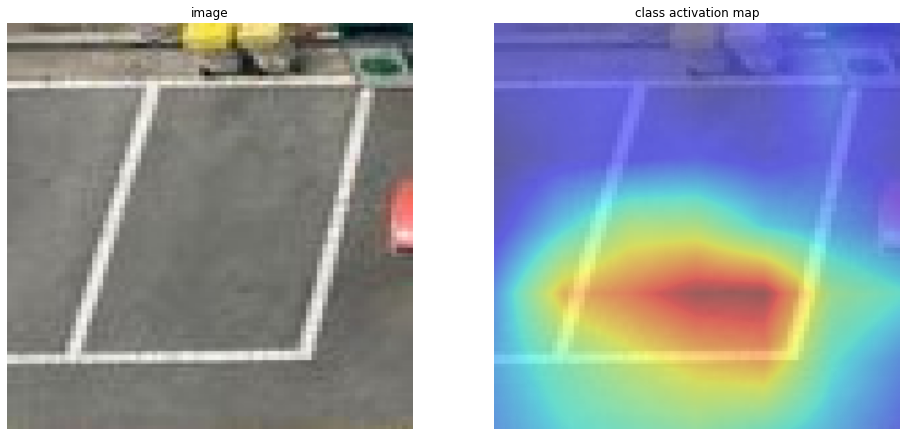

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 20)

ax[0].imshow(test_img.astype(np.uint8))
ax[0].set_title('image')
ax[0].axis('off')

ax[1].imshow(test_img.astype(np.uint8), alpha=0.5)
ax[1].imshow(final_output, cmap='jet', alpha=0.5)
ax[1].set_title('class activation map')
ax[1].axis('off')
plt.show()